In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import get_data, get_preds, get_table, plot_rsme
np.random.seed(2024)
train, test = get_data(filepath="processed_data/full_data_secs.csv", size_train=1000, size_test=800, train_tup=(2019, 2023))
train["propleft"] = 1 - train["prop"]
test["propleft"] = 1 - test["prop"]
train["propxcurr"] = train["prop"] * train["curr_pace"]
test["propxcurr"] = test["prop"] * test["curr_pace"]

train['male'] = train['gender'].apply(lambda x: 1 if x == 'M' else 0)
test['male'] = test['gender'].apply(lambda x: 1 if x == 'M' else 0)
train["propxcurr"] = train["prop"] * train["curr_pace"]
test["propxcurr"] = test["prop"] * test["curr_pace"]
train["malexage"] = train["male"] * train["age"]
test["malexage"] = test["male"] * test["age"]
train.to_csv("train.csv")
test.to_csv("test.csv")

# test = pd.read_csv("test.csv")
# plt.plot([10, 100, 256, 512, 1000], [53, 88, 201, 392, 853])

In [2]:
model_info = {
    # "rstan1a" : ("stan_results/rs_result1a.csv", ["total_pace"], ["beta[1]"], False),
    # "rstan1b" : ("stan_results/rs_result1b.csv", ["total_pace", "curr_pace"], ["beta[1]", "beta[2]"], False),
    # "rstan1c" : ("stan_results/rs_result1c.csv", ["total_pace", "prop"],  ["beta[1]", "beta[2]"], False),
    # "rstan1d" : ("stan_results/rs_result1d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], False),
    # "rstan2a" : ("stan_results/rs_result2a.csv", ["total_pace"], ["beta[1]"], True),
    # "rstan2b" : ("stan_results/rs_result2b.csv", ["total_pace", "curr_pace"],  ["beta[1]", "beta[2]"], True),
    "rstan2c" : ("stan_results/rs_result2c.csv", ["total_pace", "prop"], ["beta[1]", "beta[2]"], True),
    "rstan2d" : ("stan_results/rs_result2d.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),
    "rstan3a" : ("stan_results/rs_result3a.csv", ["total_pace", "curr_pace", "prop", "propxcurr"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]"], True),
    "rstan3b" : ("stan_results/rs_result3b.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
    # "rstan3c" : ("stan_results/rs_result3c.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "age"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
    # "rstan3d" : ("stan_results/rs_result3d.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male", "age"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]", "beta[6]"], True),
    # "rstan3e" : ("stan_results/rs_result3e.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male", "age", "malexage"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]", "beta[6]", "beta[7]"], True),
    # "rstan2d2" : ("stan_results/rs_result2d2.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
    # "rstan2d3" : ("stan_results/rs_result2d3.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
    # "rstan2d4" : ("stan_results/rs_result2d4.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
    # "rstan2d5" : ("stan_results/rs_result2d5.csv", ["total_pace", "curr_pace", "prop", "propxcurr", "male"], ["beta[1]", "beta[2]", "beta[3]", "beta[4]", "beta[5]"], True),
    # "rstan2dx" : ("stan_results/rs_result2dx.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),
    # "rstan2dy" : ("stan_results/rs_result2dy.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),
    # "rstan2dz" : ("stan_results/rs_result2dz.csv", ["total_pace", "curr_pace", "prop"], ["beta[1]", "beta[2]", "beta[3]"], True),
}
models = {k: pd.read_csv(v[0]) for k, v in model_info.items()}

In [3]:
model_preds = {}

for k, v in model_info.items():
    print(k, v)
    preds = get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3])
    model_preds[k] = preds

rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [4]:
# s_data =pd.DataFrame([[4, 0.2, .5], [3, 0.5, .5]], columns=["total_pace", "prop", "propleft"])
# get_preds(s_data, models['rstan2c'], feats_lis = ["total_pace", "prop"], beta_lis = ["beta[1]", "beta[2]"], full=True)

In [5]:
test2 = test.copy()
for k, v in model_preds.items():
    test2[k] = get_table(v)["stan"]
test2["extrap"] = get_table(model_preds["rstan2d"])["extrap"]
test2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,propxcurr,male,malexage,rstan2c,rstan2d,rstan3a,rstan3b,extrap
12,286789,5K,5.773672,5.773672,5.373790,29,M,2023,0.118497,0.881503,0.684165,1,29,-3.456544,-3.624828,-6.552906,-6.468759,-9.063767
138,286915,5K,4.770992,4.770992,4.692504,26,M,2023,0.118497,0.881503,0.565350,1,26,5.855832,5.860806,3.325691,3.142738,-2.465467
140,286917,5K,5.117707,5.117707,4.687292,40,M,2023,0.118497,0.881503,0.606435,1,40,-5.640107,-5.615590,-8.321285,-8.514405,-12.618283
153,286930,5K,4.664179,4.664179,4.673275,33,M,2023,0.118497,0.881503,0.552693,1,33,8.618292,8.801979,6.257642,6.052480,0.293467
162,286939,5K,4.739336,4.739336,4.659856,35,M,2023,0.118497,0.881503,0.561599,1,35,5.816086,5.732721,2.899057,3.074450,-2.530917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208029,312610,40K,1.785714,2.004912,1.991833,56,M,2023,0.947980,0.052020,1.692821,1,56,-0.921817,-1.237613,-1.727930,-1.813137,-2.303148
208086,312667,40K,1.794044,1.979218,1.970164,71,F,2023,0.947980,0.052020,1.700717,0,0,-0.157599,-1.069042,-1.582827,-2.393469,-1.632937
208186,312767,40K,1.740947,1.925113,1.923375,36,F,2023,0.947980,0.052020,1.650382,0,0,1.173365,0.241618,-0.430364,-1.237198,-0.330121
208194,312775,40K,1.773679,1.910950,1.908499,47,M,2023,0.947980,0.052020,1.681411,1,47,1.066923,-0.699192,-1.341036,-1.430558,-0.472608


In [6]:
# import seaborn as sns
# marks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
# for mark in marks:
#     sns.kdeplot(test2[test2["dist"] == mark]["rstan2d"], label=mark)
# plt.xlim(-20, 20)
# plt.legend()
# plt.show()
# for m in model_info.keys():
#     sns.kdeplot(test2[m], label=m)

# plt.xlim(-20, 20)
# plt.legend()

,extrap,rstan3a,rstan3b,rstan2c,rstan2d
dist,,,,,
5K,17.314686,16.430313,16.286693,16.040126,15.858506
10K,16.557909,12.707727,12.585156,12.704090,12.454667
15K,15.162284,10.520502,10.452664,10.726324,10.480499
20K,12.890271,8.511465,8.447812,8.775624,8.461915
25K,10.936394,6.883588,6.852217,7.277804,6.940754
30K,7.627967,5.174646,5.108857,5.509850,5.064502
35K,4.272465,3.408417,3.297885,3.722756,3.295172
40K,1.176863,0.992239,1.071149,1.096930,0.981820


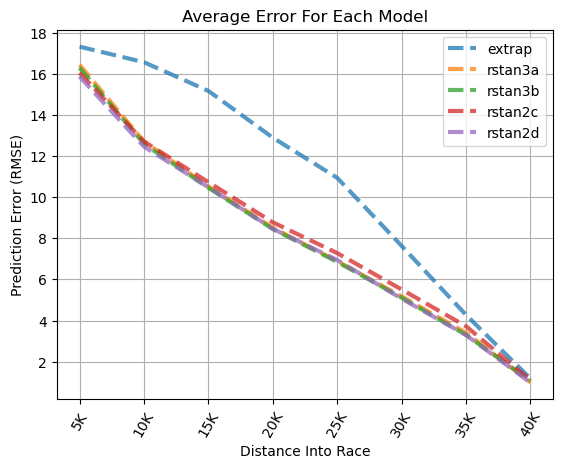

In [7]:
table_group = plot_rsme(test2, ["extrap", "rstan3a", "rstan3b", "rstan2c", "rstan2d"], "all_errors3")
table_group

In [8]:
# test2.groupby(["dist"])[labels].apply(lambda x: (x ** 2).sum()).loc[mks]
# 1 - (((test2[labels]) ** 2).sum()/((((42195/60) / test2["finish"]) - ((42195/60) / test2["finish"]).mean()) ** 2).sum()) # r squared

In [9]:
model_preds2 = {}

for k, v in model_info.items():
    print(k, v)
    preds = (42195 / 60) / get_preds(test, pd.read_csv(v[0]), feats_lis=v[1], beta_lis=v[2], propleft=v[3], full=True)
    model_preds2[k] = preds

rstan2c ('stan_results/rs_result2c.csv', ['total_pace', 'prop'], ['beta[1]', 'beta[2]'], True)
rstan2d ('stan_results/rs_result2d.csv', ['total_pace', 'curr_pace', 'prop'], ['beta[1]', 'beta[2]', 'beta[3]'], True)
rstan3a ('stan_results/rs_result3a.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]'], True)
rstan3b ('stan_results/rs_result3b.csv', ['total_pace', 'curr_pace', 'prop', 'propxcurr', 'male'], ['beta[1]', 'beta[2]', 'beta[3]', 'beta[4]', 'beta[5]'], True)


In [10]:
def add_intervals_to_test(data_tbl, pred_names):
    data = data_tbl.copy()
    for pred_name in pred_names:
        for conf, lower, upper in [(50, 25, 75), (80, 10, 90), (95, 2.5, 97.5)]:
            test_true = (42195 / 60) / data["finish"]
            b1, b2 = np.percentile(model_preds2[pred_name], [lower, upper], axis=1)
            data[f"{pred_name}-lower{conf}"] = b1
            data[f"{pred_name}-upper{conf}"] = b2
            data[f"{pred_name}-size{conf}"] = b2 - b1
            data[f"{pred_name}-in{conf}"] = (test_true < b2) & (test_true > b1)
    return data

In [11]:
pred_names = ["rstan3a", "rstan3b", "rstan2c", "rstan2d"]
table2 = add_intervals_to_test(test2, pred_names)
table2

,id,dist,curr_pace,total_pace,finish,age,gender,year,prop,propleft,...,rstan2d-size50,rstan2d-in50,rstan2d-lower80,rstan2d-upper80,rstan2d-size80,rstan2d-in80,rstan2d-lower95,rstan2d-upper95,rstan2d-size95,rstan2d-in95
12,286789,5K,5.773672,5.773672,5.373790,29,M,2023,0.118497,0.881503,...,7.507345,True,120.800199,135.042534,14.242335,True,117.544345,139.277935,21.733590,True
138,286915,5K,4.770992,4.770992,4.692504,26,M,2023,0.118497,0.881503,...,10.804703,False,145.715052,166.725716,21.010664,True,141.356125,173.348973,31.992847,True
140,286917,5K,5.117707,5.117707,4.687292,40,M,2023,0.118497,0.881503,...,9.470443,False,136.101139,153.954131,17.852992,True,131.871585,159.185281,27.313696,True
153,286930,5K,4.664179,4.664179,4.673275,33,M,2023,0.118497,0.881503,...,11.667819,False,149.039434,171.553142,22.513708,True,143.995967,178.533117,34.537149,True
162,286939,5K,4.739336,4.739336,4.659856,35,M,2023,0.118497,0.881503,...,11.446273,False,146.696117,168.146283,21.450165,True,141.949564,174.818875,32.869311,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208029,312610,40K,1.785714,2.004912,1.991833,56,M,2023,0.947980,0.052020,...,3.223563,True,348.699815,354.870084,6.170269,True,346.859495,356.575654,9.716160,True
208086,312667,40K,1.794044,1.979218,1.970164,71,F,2023,0.947980,0.052020,...,3.347775,True,352.697847,359.181649,6.483801,True,350.935532,360.889850,9.954318,True
208186,312767,40K,1.740947,1.925113,1.923375,36,F,2023,0.947980,0.052020,...,3.749622,True,362.378130,369.387302,7.009173,True,360.601995,371.224424,10.622428,True
208194,312775,40K,1.773679,1.910950,1.908499,47,M,2023,0.947980,0.052020,...,3.567753,True,364.364617,371.214974,6.850357,True,362.402338,373.051162,10.648823,True


/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/opt/anaconda3/envs/pyenv10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

,rstan3a-in50,rstan3b-in50,rstan2c-in50,rstan2d-in50,rstan3a-in80,rstan3b-in80,rstan2c-in80,rstan2d-in80,rstan3a-in95,rstan3b-in95,rstan2c-in95,rstan2d-in95
dist,,,,,,,,,,,,
5K,0.49625,0.50750,0.52250,0.47250,0.89125,0.89625,0.91875,0.88375,0.98875,0.98750,0.99750,0.99250
10K,0.58625,0.59125,0.58750,0.54750,0.92250,0.92625,0.96250,0.93375,0.99500,0.99375,0.99875,0.99500
15K,0.61125,0.61125,0.62750,0.58625,0.93125,0.93250,0.95000,0.93250,0.99375,0.99250,0.99500,0.99250
20K,0.61875,0.62250,0.62625,0.60000,0.92125,0.92750,0.94000,0.91875,0.98500,0.98375,0.99125,0.98750
25K,0.62375,0.63125,0.62875,0.61750,0.92250,0.91875,0.92250,0.91875,0.97125,0.97250,0.98000,0.97000
30K,0.58625,0.60375,0.58500,0.58125,0.91000,0.91875,0.90625,0.90500,0.97375,0.97125,0.97500,0.97375
35K,0.49375,0.55375,0.51125,0.52875,0.90250,0.91000,0.85875,0.90250,0.98250,0.98125,0.97125,0.98125
40K,0.72125,0.61000,0.51875,0.73250,0.92250,0.90250,0.84125,0.92125,0.97375,0.97125,0.96250,0.97125


<Figure size 4000x4000 with 0 Axes>

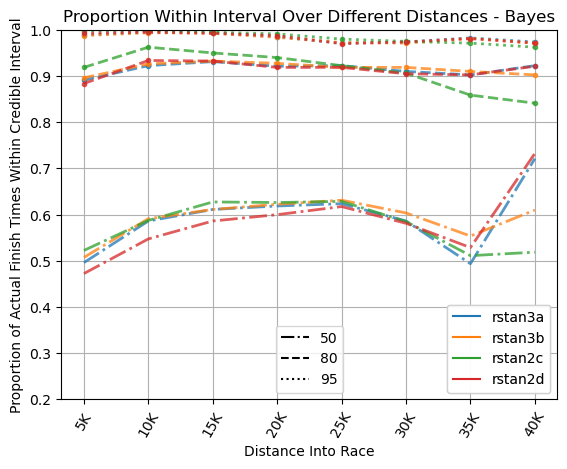

In [12]:
from matplotlib.lines import Line2D
mks = ["5K", "10K", "15K", "20K", "25K", "30K", "35K", "40K"]
n = len(pred_names)
colors = [f"C{i}" for i in range(len(pred_names))] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"{p}-in{conf}" for p in pred_names]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: np.sum(x) / len(x)).loc[mks]
    tables.append(table3)

plt.figure(figsize=(40, 40))
big_table = pd.concat(tables, axis=1)
ax = big_table.plot(label=big_table.columns,  style=["-."] * n + ["--."] * n + [":."] * n , linewidth=2, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Proportion of Actual Finish Times Within Credible Interval")
plt.xticks(rotation=60)
plt.ylim(0.2, 1)
plt.title("Proportion Within Interval Over Different Distances - Bayes")
plt.grid(True)
plt.legend()
leg1 = plt.legend([Line2D([0,1],[0,1],linestyle=s, color='black') for s in ["-.", "--", ":"]], ["50", "80", "95"], loc="lower center")
ax.add_artist(leg1)
leg2 = plt.legend([Line2D([0,1],[0,1], color=c) for c in colors[:n]], pred_names, loc="lower right")
ax.add_artist(leg2)
plt.savefig("analysis/interval_check.png", bbox_inches="tight")
big_table

,rstan3a-size50,rstan3b-size50,rstan2c-size50,rstan2d-size50,rstan3a-size80,rstan3b-size80,rstan2c-size80,rstan2d-size80,rstan3a-size95,rstan3b-size95,rstan2c-size95,rstan2d-size95
dist,,,,,,,,,,,,
5K,26.899394,26.765925,29.408129,26.577364,51.614222,51.383027,56.492745,50.907258,80.412267,80.033716,88.508703,79.239712
10K,22.431057,22.363848,24.672817,22.239738,42.923792,42.785041,47.314935,42.533682,66.528583,66.177785,73.470986,65.844147
15K,18.614772,18.536762,20.506312,18.464573,35.498929,35.442514,39.200351,35.287090,54.727744,54.634786,60.609373,54.531942
20K,15.108346,15.031548,16.584379,14.990203,28.779234,28.668629,31.682729,28.593498,44.250279,44.105889,48.787038,43.987769
25K,11.545991,11.539904,12.758183,11.515988,21.994258,21.954169,24.293232,21.895400,33.744078,33.688013,37.296233,33.641389
30K,8.272584,8.254855,9.113139,8.261642,15.725024,15.676227,17.314998,15.711858,24.090018,24.014503,26.532545,24.092363
35K,4.886854,4.867813,5.395903,4.899591,9.295215,9.265971,10.263375,9.322315,14.209158,14.156021,15.708033,14.249432
40K,1.469929,1.465466,1.638546,1.477316,2.791067,2.786591,3.114163,2.809831,4.261371,4.263125,4.755052,4.289485


<Figure size 3000x2000 with 0 Axes>

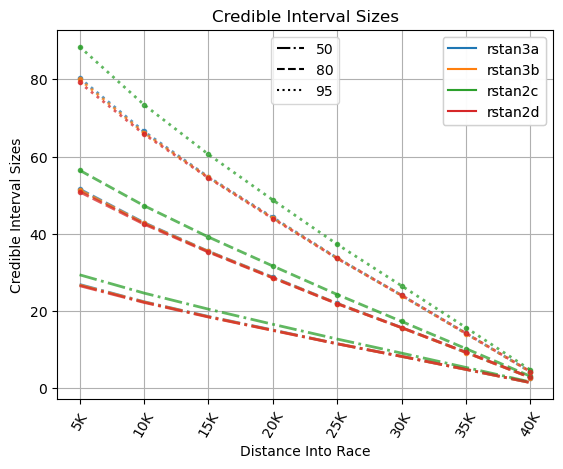

In [13]:
n = len(pred_names)
colors = [f"C{i}" for i in range(len(pred_names))] * 3
tables = []
for conf, style in [(50, "-."), (80, "--."), (95, ":.")]:
    sublabels = [f"{p}-size{conf}" for p in pred_names]
    table3 = table2.groupby(["dist"])[sublabels].apply(lambda x: (x ** 2).mean() ** 0.5).loc[mks]
    tables.append(table3)

plt.figure(figsize=(30, 20))
big_table = pd.concat(tables, axis=1)
ax = big_table.plot(label=big_table.columns,  style= ["-."] * n + ["--."] * n + [":."] * n  , linewidth=2, grid=True, alpha=0.75, color=colors)

plt.xlabel("Distance Into Race")
plt.ylabel("Credible Interval Sizes")
plt.xticks(rotation=60)
plt.title("Credible Interval Sizes")
plt.grid(True)

leg1 = plt.legend([Line2D([0,1],[0,1],linestyle=s, color='black') for s in ["-.", "--", ":"]], ["50", "80", "95"], loc="upper center")
ax.add_artist(leg1)
leg2 = plt.legend([Line2D([0,1],[0,1], color=c) for c in colors[:n]], pred_names, loc="upper right")
ax.add_artist(leg2)

plt.savefig("analysis/interval_sizes.png", bbox_inches="tight")
big_table